In [24]:
#%load_ext autoreload
#%autoreload 2


import sys
sys.path.append("../../mrf-sim/")
sys.path.append("../../epgpy/")
sys.path.append("../../machines/")
sys.path.append("../../mutools/")
sys.path.append("../../dicomstack/")


#import matplotlib
#matplotlib.u<se("TkAgg")
from mrfsim import T1MRF
from image_series import *
from dictoptimizers import SimpleDictSearch,BruteDictSearch
from utils_mrf import *

import json
import readTwix as rT
import time
import os
from numpy.lib.format import open_memmap
from numpy import memmap
import pickle
from scipy.io import loadmat,savemat
import twixtools
from mutools import io
import cv2
import scipy
%matplotlib inline

import numpy as np


# Noisy dico signals

In [25]:
dictfile='../mrf144w8_SeqFF_PWCR_RecoFFDf_light.dict'
#dictfile='../mrf175_SimReco2_light.dict'
mrfdict = dictsearch.Dictionary()
mrfdict.load(dictfile, force=True)
total_nb_signals=mrfdict.values.shape[0]

In [26]:
mask=None
snr=1000
ff=0.5
nb_signals=60

In [27]:
#nb_signals=np.minimum(nb_signals,total_nb_signals)

phase_0=np.pi*np.random.uniform()
print(phase_0)
ind=np.random.choice(total_nb_signals,size=nb_signals)
keys=np.array(mrfdict.keys)[ind]
all_signals=((1-ff)*mrfdict.values[ind,:,0].T+ff*mrfdict.values[ind,:,1].T)*np.exp(-1j*phase_0)

noise=(np.random.normal(size=(all_signals.shape))+1j*np.random.normal(size=(all_signals.shape)))
noise*=np.abs(np.expand_dims(np.mean(all_signals,axis=1),axis=1))/snr/np.abs(noise)
all_signals=all_signals+noise
all_signals/=np.linalg.norm(all_signals,axis=0)

2.6582541072217487


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


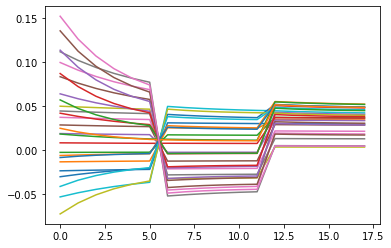

In [31]:
plt.plot(mrfdict.values[:,:,1].T)

In [5]:
pca = True
threshold_pca_bc = 20
threshold_pca_brute=20

In [6]:
nb_signals=all_signals.shape[1]
split=nb_signals+1

In [7]:
dict_optim_brute=BruteDictSearch(FF_list=np.arange(0,1.01,0.01),mask=mask,split=split,pca=pca,threshold_pca=threshold_pca_brute,log=False,useGPU_dictsearch=False,ntimesteps=None,log_phase=False,return_matched_signals=True)
dict_optim_bc_cf =SimpleDictSearch(mask=mask, niter=0, seq=None, trajectory=None, split=split, pca=pca,
                                threshold_pca=threshold_pca_bc, log=False, useGPU_dictsearch=False, useGPU_simulation=False,
                                gen_mode="other", movement_correction=False, cond=None, ntimesteps=None,return_matched_signals=True)
dict_optim_bc_matrix = dict_optim_bc_cf

In [8]:


all_maps_brute,matched_signals_brute=dict_optim_brute.search_patterns(dictfile,all_signals)
all_maps_bc_cf,matched_signals_bc_cf=dict_optim_bc_cf.search_patterns_test(dictfile,all_signals)
all_maps_bc_matrix,matched_signals_bc_matrix=dict_optim_bc_matrix.search_patterns_matrix(dictfile,all_signals)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 290.44it/s]

Calculating optimal fat fraction and best pattern per signal
There are 60 unique signals to match along 2727 dic components
Building the maps for iteration
Water Components Retained 20 out of 18 timesteps
Fat Components Retained 20 out of 18 timesteps
################# ITERATION : Number 0 out of 0 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 0
There are 60 unique signals to match along 27 water and 27 fat components
(60,)
(60,)
(18, 60)
Maps build for iteration 0
There are 60 unique signals to match along 27 components


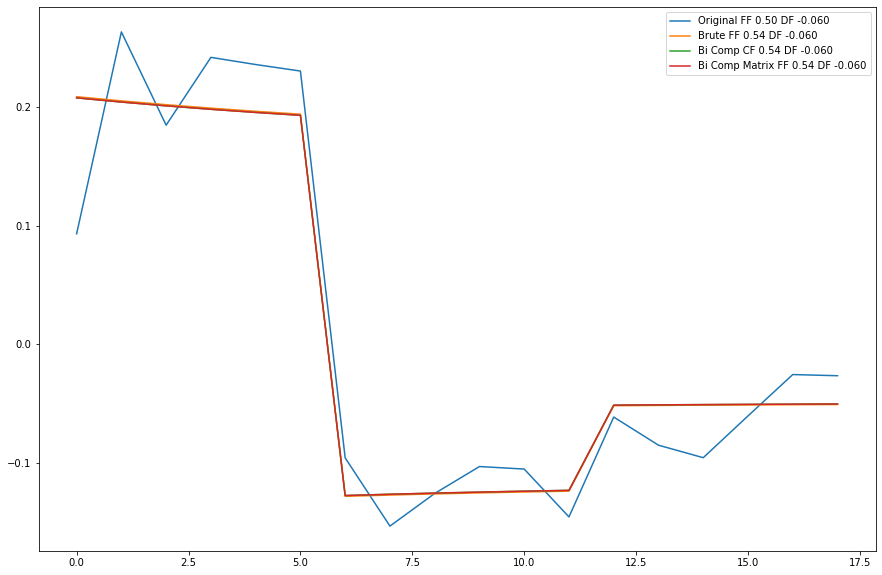

In [9]:
j=np.random.choice(nb_signals)
metric=np.real
plt.figure(figsize=(15,10))
plt.plot(metric(all_signals[:,j]),label="Original FF {0:.2f} DF {1:.3f}".format(ff,keys[j,-1]))
plt.plot(metric(matched_signals_brute[:,j]),label="Brute FF {0:.2f} DF {1:.3f}".format(all_maps_brute[0][0]["ff"][j],all_maps_brute[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_cf[:,j]),label="Bi Comp CF {0:.2f} DF {1:.3f}".format(all_maps_bc_cf[0][0]["ff"][j],all_maps_bc_cf[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_matrix[:,j]),label="Bi Comp Matrix FF {0:.2f} DF {1:.3f}".format(all_maps_bc_matrix[0][0]["ff"][j],all_maps_bc_matrix[0][0]["df"][j]))
plt.legend()

In [10]:
correls_bc_matrix=[]
correls_bc_cf=[]
correls_brute=[]

correls_brute=[]
for i in range(nb_signals):
    correls_bc_matrix.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_matrix[:,i]))[0,1])
    correls_brute.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_brute[:,i]))[0,1])
    correls_bc_cf.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_cf[:,i]))[0,1])
    
correls_bc_matrix=np.array(correls_bc_matrix)
correls_bc_cf=np.array(correls_bc_cf)
correls_brute=np.array(correls_brute)


In [11]:
df_correls = pd.DataFrame(columns=["Brute","BC Matrix","BC CF"],data=np.stack([correls_brute,correls_bc_matrix,correls_bc_cf],axis=-1))

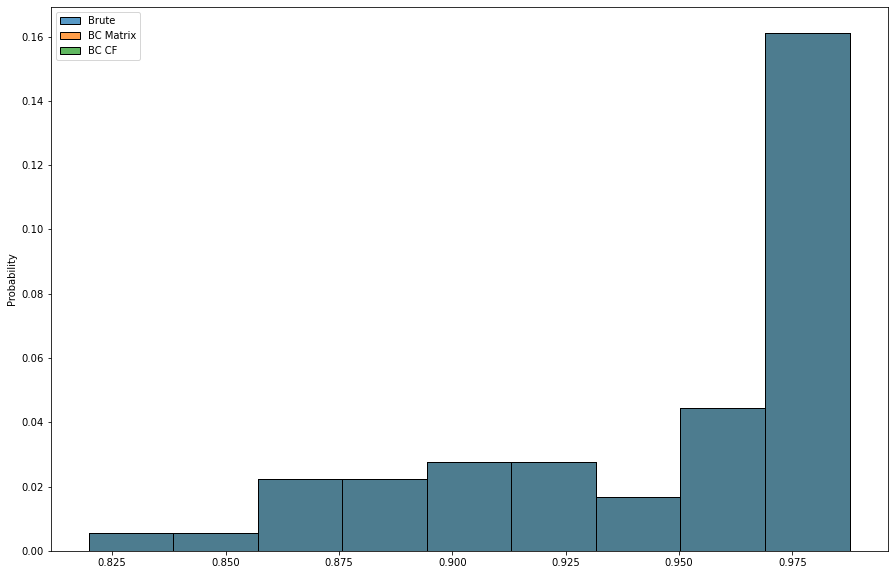

In [12]:
import seaborn as sns
plt.figure(figsize=(15,10))
#df_correls, hist = False, kde = True,
#                 kde_kws = {'shade': True, 'linewidth': 3})

sns.histplot(df_correls,stat="probability");

In [13]:
data_ff=pd.DataFrame(data=np.stack([[ff]*nb_signals,all_maps_brute[0][0]["ff"],all_maps_bc_cf[0][0]["ff"],all_maps_bc_matrix[0][0]["ff"]],axis=-1),columns=["FF Truth","FF Brute","FF CF","FF Matrix"])
data_df=pd.DataFrame(data=np.stack([keys[:,-1],all_maps_brute[0][0]["df"],all_maps_bc_cf[0][0]["df"],all_maps_bc_matrix[0][0]["df"]],axis=-1),columns=["DF Truth","DF Brute","DF CF","DF Matrix"])

data=pd.concat([data_df,data_ff],axis=1)

In [14]:
cols_df=[col for col in data.columns if "DF" in col]
df_min=data.describe()[cols_df].loc["min",:].min()
df_max=data.describe()[cols_df].loc["max",:].max()

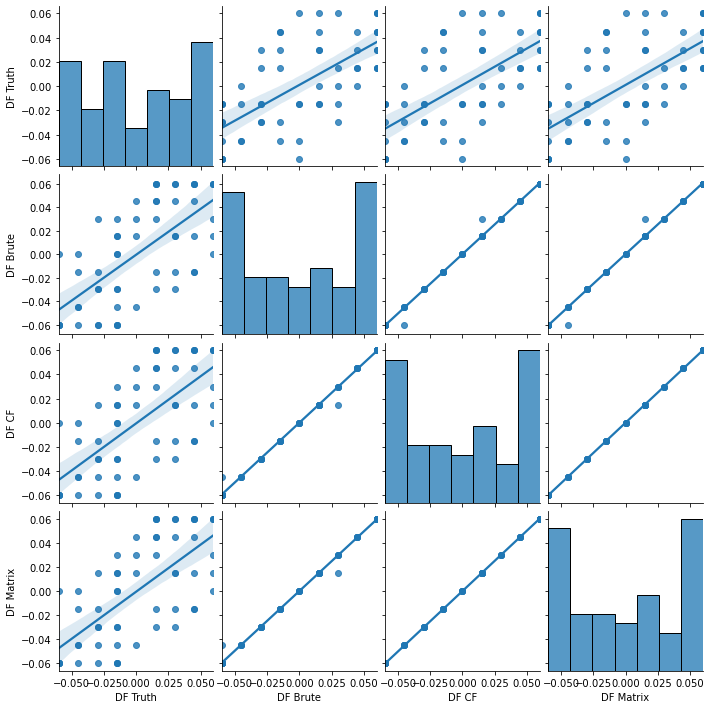

In [22]:
sns.pairplot(data_df,kind='reg')

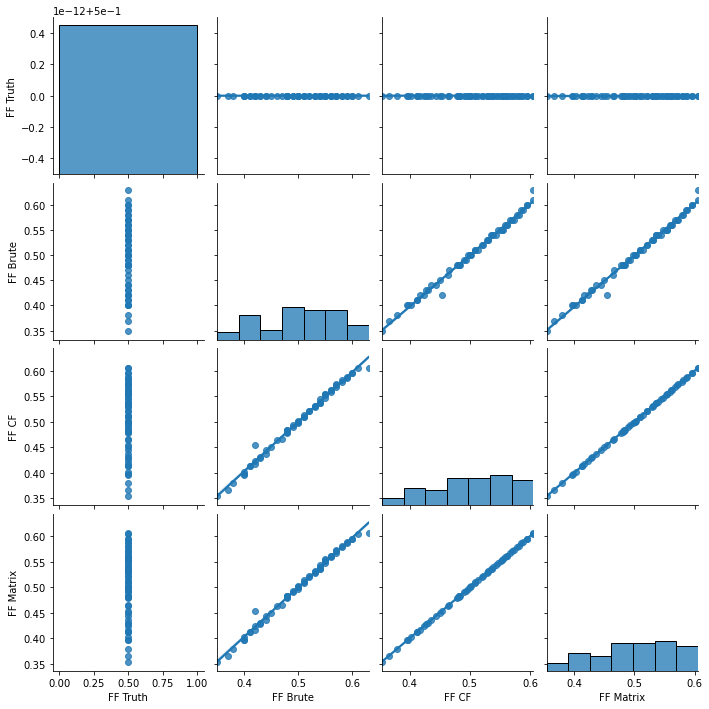

In [23]:
sns.pairplot(data_ff,kind='reg')

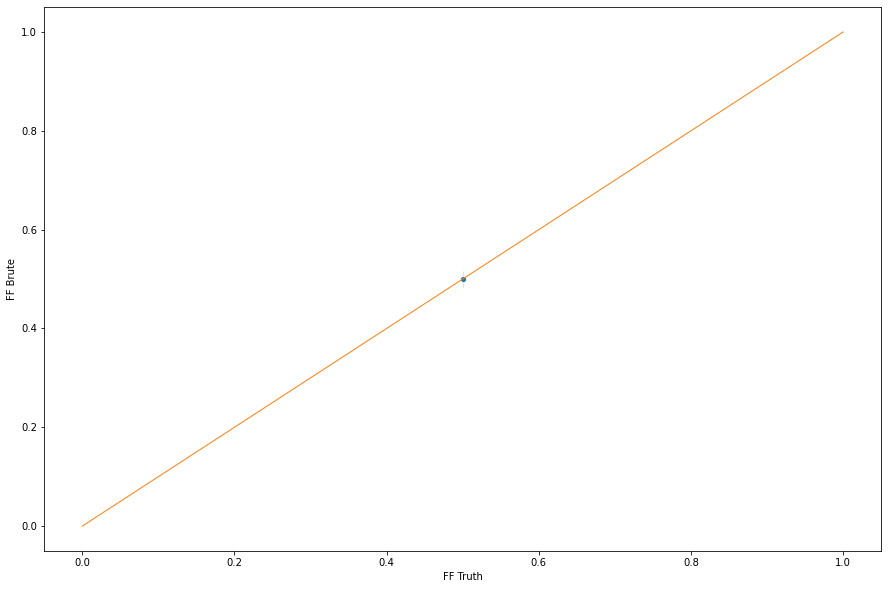

In [15]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Truth",y="FF Brute",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

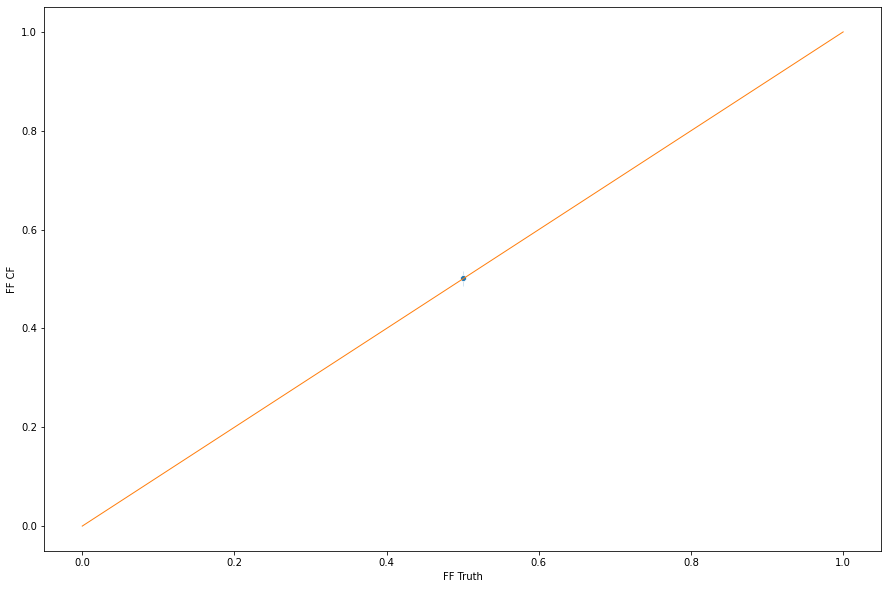

In [16]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Truth",y="FF CF",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

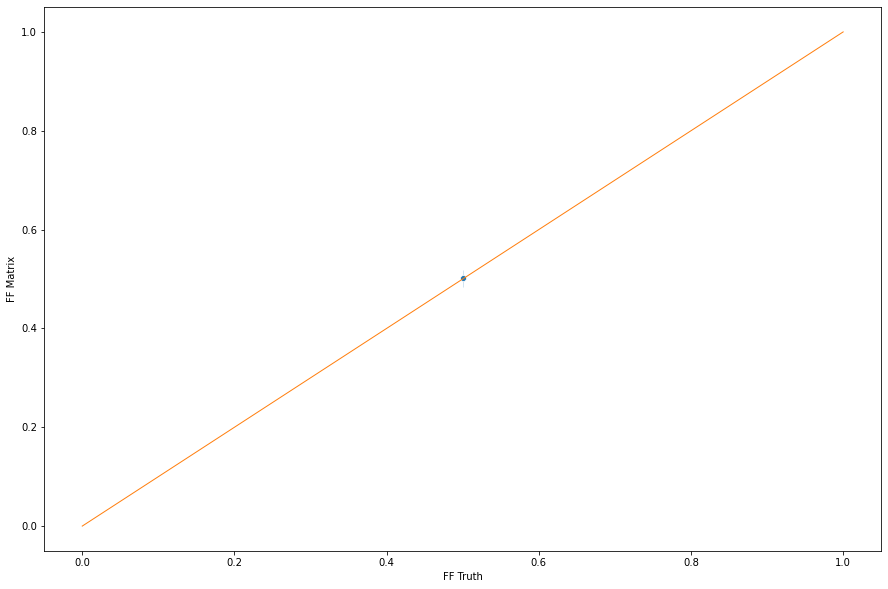

In [17]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Truth",y="FF Matrix",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

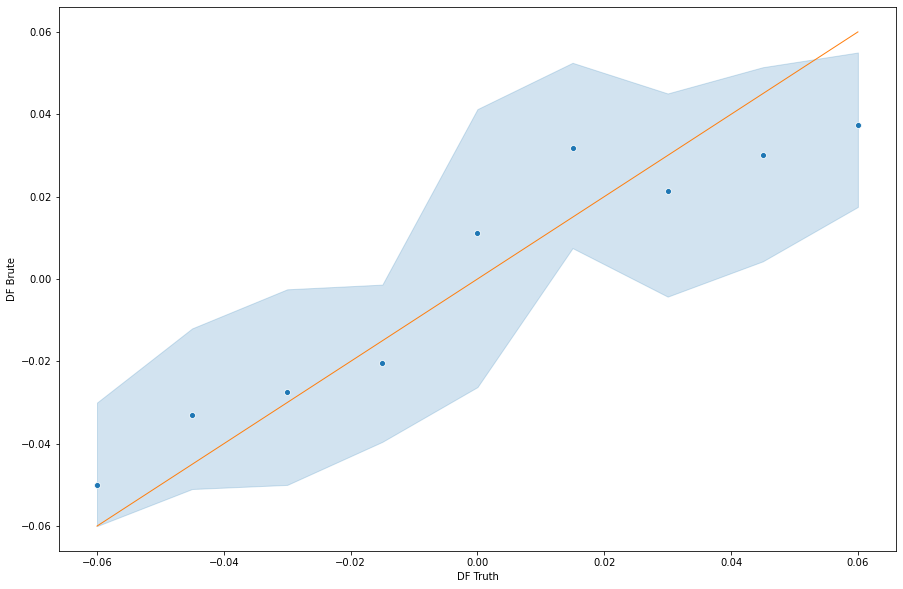

In [18]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Truth",y="DF Brute",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

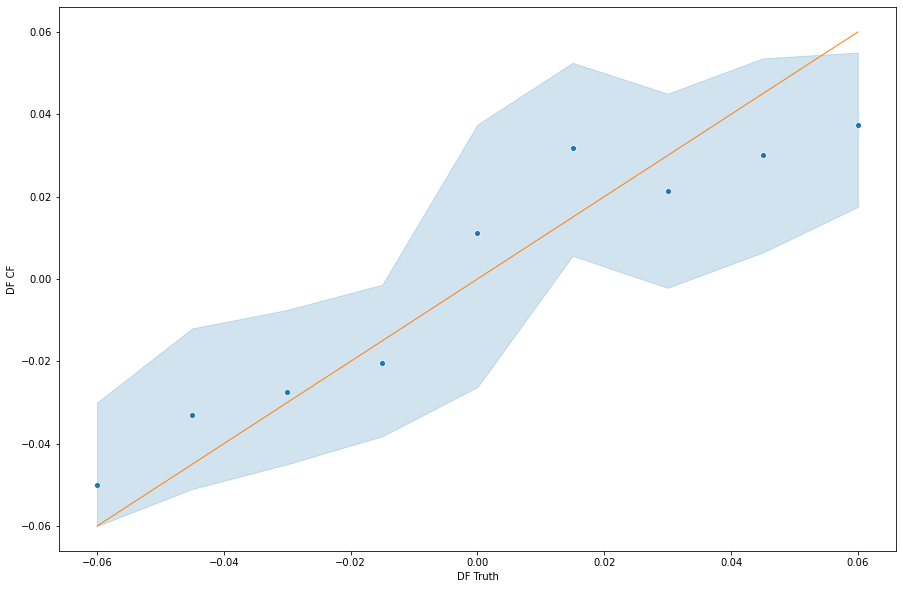

In [19]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Truth",y="DF CF",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

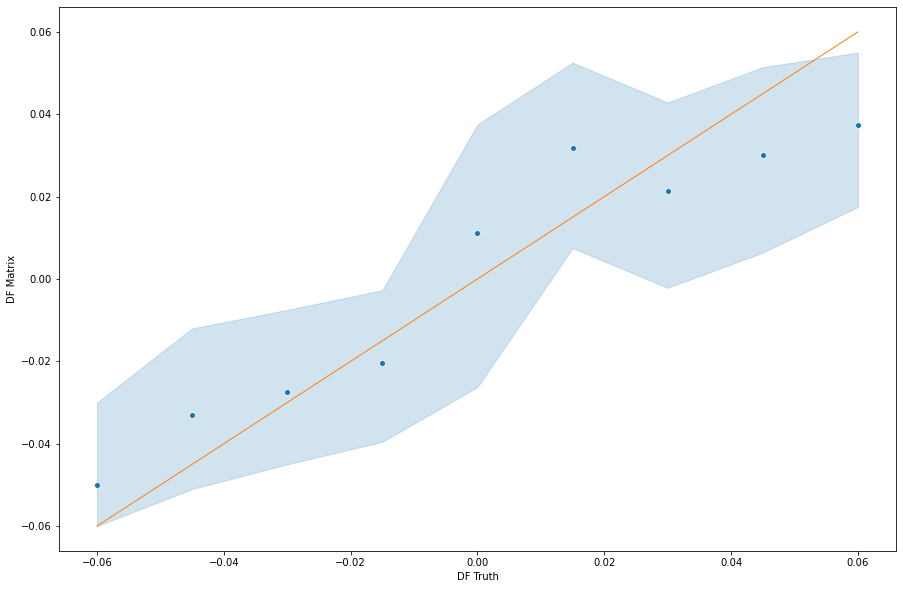

In [20]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Truth",y="DF Matrix",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

# Simulation

## FF MRF

In [2]:

base_folder = "../3D"

suffix=""
suffix="_FFDf"
#suffix="_Cohen"
#suffix="_CohenWeighted"
#suffix="_CohenCSWeighted"
#suffix="_CohenBS"
#suffix="_PW"
suffix="_PWCR"
#suffix="_PWWeighted"
#suffix="_"

nb_allspokes = 144
nspoke=8
nb_segments=nb_allspokes
ntimesteps=int(nb_segments/nspoke)





nb_filled_slices = 8
nb_empty_slices=2
repeat_slice=1
nb_slices = nb_filled_slices+2*nb_empty_slices

undersampling_factor=1

is_random=False
frac_center=1.0

name = "SquareSimu3D"


localfile="/"+name
filename = base_folder+localfile

folder = "/".join(str.split(filename,"/")[:-1])

filename_volume = filename+"_volumes_sl{}_rp{}_us{}_{}w{}{}.npy".format(nb_slices,repeat_slice,undersampling_factor,nb_allspokes,nspoke,suffix)
filename_mask= filename+"_mask_sl{}_rp{}_us{}{}w{}{}.npy".format(nb_slices,repeat_slice,undersampling_factor,nb_allspokes,nspoke,suffix)
filename_paramMap=filename+"_paramMap_sl{}_rp{}{}.pkl".format(nb_slices,repeat_slice,"")



dictfile='../mrf144w8_SeqFF_PWCR_RecoFFDf_light.dict'

In [3]:
mask=np.load(filename_mask)
volumes_all=np.load(filename_volume)
with open(filename_paramMap, "rb") as file:
    paramMap=pickle.load(file)


In [4]:
all_signals=volumes_all[:,mask>0]
all_signals/=np.linalg.norm(all_signals,axis=0)

In [5]:
nb_signals=10000

In [6]:
total_nb_signals=all_signals.shape[1]

nb_signals=np.minimum(total_nb_signals,nb_signals)
ind=np.random.choice(total_nb_signals,size=nb_signals,replace=False)
ff_gt=paramMap["ff"][ind]
df_gt=paramMap["df"][ind]

all_signals=all_signals[:,ind]


In [7]:
pca = True
threshold_pca_bc = 20
threshold_pca_brute=20

In [8]:
nb_signals=all_signals.shape[1]
split=nb_signals+1
dict_optim_brute=BruteDictSearch(FF_list=np.arange(0,1.01,0.01),mask=mask,split=split,pca=pca,threshold_pca=threshold_pca_brute,log=False,useGPU_dictsearch=False,ntimesteps=None,log_phase=False,return_matched_signals=True)
dict_optim_bc =SimpleDictSearch(mask=mask, niter=0, seq=None, trajectory=None, split=split, pca=pca,
                                threshold_pca=threshold_pca_bc, log=False, useGPU_dictsearch=False, useGPU_simulation=False,
                                gen_mode="other", movement_correction=False, cond=None, ntimesteps=None,return_matched_signals=True)
#dict_optim_bc_matrix = dict_optim_bc_cf



all_maps_brute,matched_signals_brute=dict_optim_brute.search_patterns(dictfile,all_signals)
all_maps_bc_cf,matched_signals_bc_cf=dict_optim_bc.search_patterns_test(dictfile,all_signals)
all_maps_bc_matrix,matched_signals_bc_matrix=dict_optim_bc.search_patterns_matrix(dictfile,all_signals)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Calculating optimal fat fraction and best pattern per signal
There are 8192 unique signals to match along 2727 dic components


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]


Building the maps for iteration


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Water Components Retained 20 out of 18 timesteps
Fat Components Retained 20 out of 18 timesteps
################# ITERATION : Number 0 out of 0 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 0
There are 8192 unique signals to match along 27 water and 27 fat components
(8192,)
(8192,)
(18, 8192)
Maps build for iteration 0
There are 8192 unique signals to match along 27 components


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


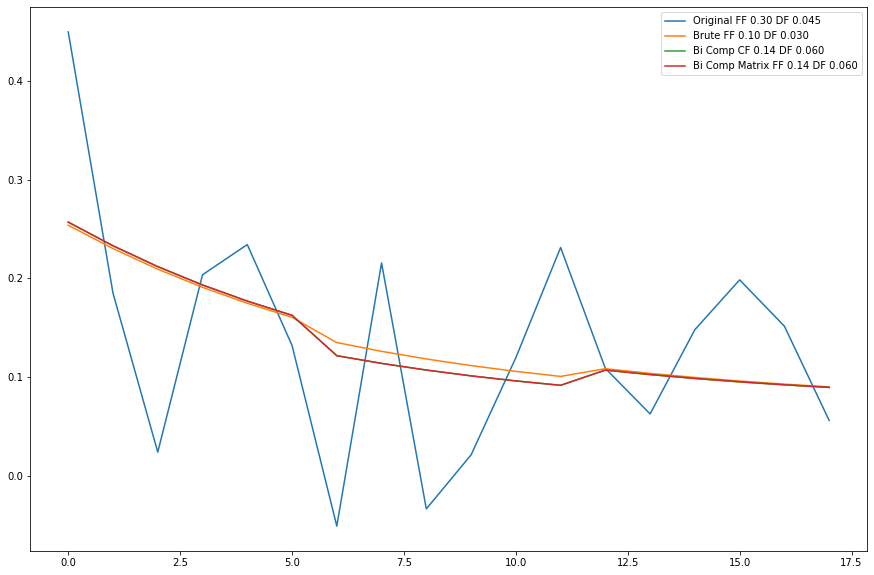

In [10]:
j=np.random.choice(nb_signals)
metric=np.real
plt.figure(figsize=(15,10))
plt.plot(metric(all_signals[:,j]),label="Original FF {0:.2f} DF {1:.3f}".format(ff_gt[j],df_gt[j]))
plt.plot(metric(matched_signals_brute[:,j]),label="Brute FF {0:.2f} DF {1:.3f}".format(all_maps_brute[0][0]["ff"][j],all_maps_brute[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_cf[:,j]),label="Bi Comp CF {0:.2f} DF {1:.3f}".format(all_maps_bc_cf[0][0]["ff"][j],all_maps_bc_cf[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_matrix[:,j]),label="Bi Comp Matrix FF {0:.2f} DF {1:.3f}".format(all_maps_bc_matrix[0][0]["ff"][j],all_maps_bc_matrix[0][0]["df"][j]))
plt.legend()

In [11]:
correls_bc_matrix=[]
correls_bc_cf=[]
correls_brute=[]

correls_brute=[]
for i in range(nb_signals):
    correls_bc_matrix.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_matrix[:,i]))[0,1])
    correls_brute.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_brute[:,i]))[0,1])
    correls_bc_cf.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_cf[:,i]))[0,1])
    
correls_bc_matrix=np.array(correls_bc_matrix)
correls_bc_cf=np.array(correls_bc_cf)
correls_brute=np.array(correls_brute)
df_correls = pd.DataFrame(columns=["Brute","BC Matrix","BC CF"],data=np.stack([correls_brute,correls_bc_matrix,correls_bc_cf],axis=-1))

<Figure size 1080x720 with 0 Axes>

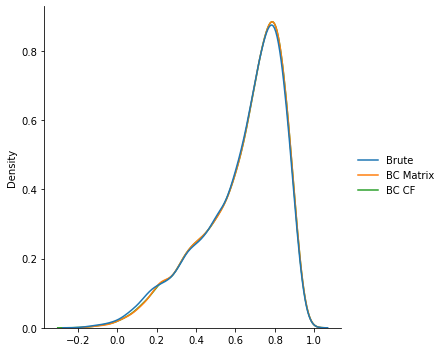

In [12]:
import seaborn as sns
plt.figure(figsize=(15,10))

sns.displot(df_correls,kind="kde");

In [13]:
df_correls.describe()

,Brute,BC Matrix,BC CF
count,8192.000000,8192.000000,8192.000000
mean,0.636617,0.642378,0.641962
std,0.206993,0.202511,0.203082
min,-0.172837,-0.143332,-0.201201
25%,0.517819,0.524645,0.523967
50%,0.694219,0.697926,0.697599
75%,0.794247,0.796821,0.796821
max,0.965192,0.965125,0.965125


In [14]:
data_ff=pd.DataFrame(data=np.stack([all_maps_brute[0][0]["ff"],all_maps_bc_cf[0][0]["ff"],all_maps_bc_matrix[0][0]["ff"]],axis=-1),columns=["FF Brute","FF CF","FF Matrix"])
data_df=pd.DataFrame(data=np.stack([all_maps_brute[0][0]["df"],all_maps_bc_cf[0][0]["df"],all_maps_bc_matrix[0][0]["df"]],axis=-1),columns=["DF Brute","DF CF","DF Matrix"])

data=pd.concat([data_df,data_ff],axis=1)


In [15]:
cols_df=[col for col in data.columns if "DF" in col]
df_min=data.describe()[cols_df].loc["min",:].min()
df_max=data.describe()[cols_df].loc["max",:].max()

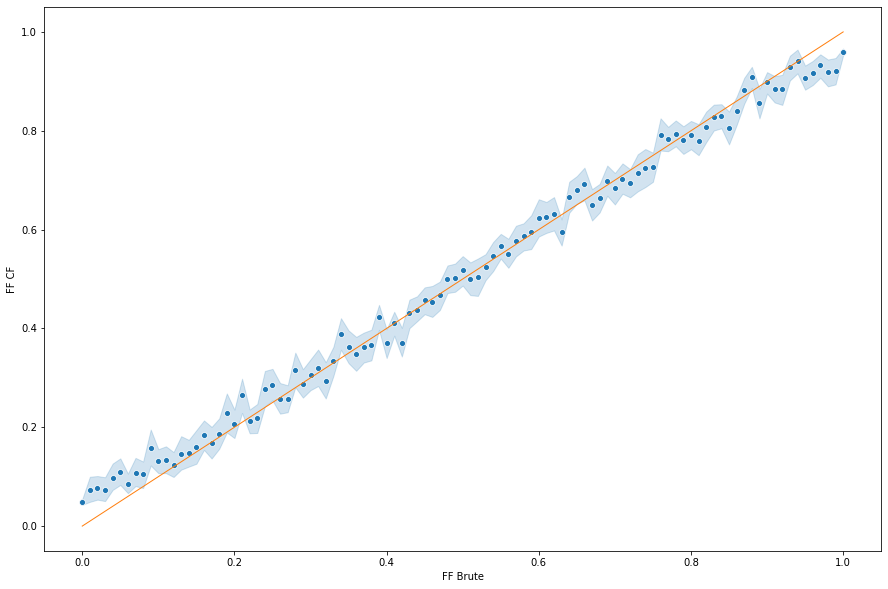

In [16]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Brute",y="FF CF",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

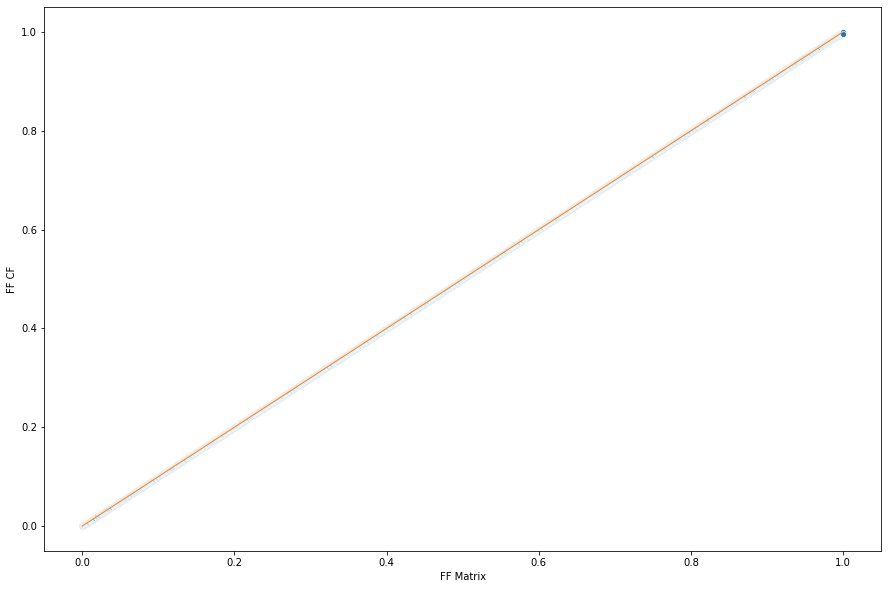

In [17]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Matrix",y="FF CF",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

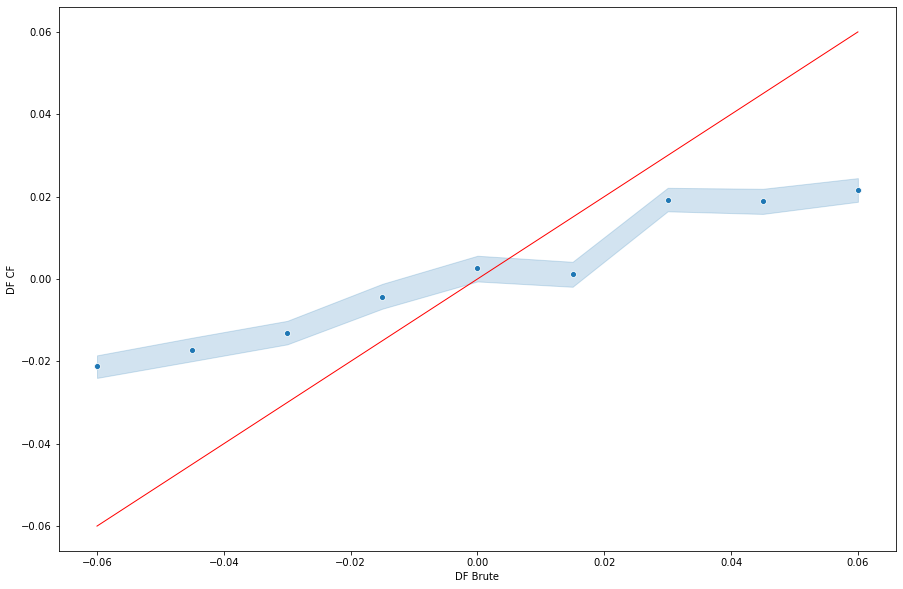

In [18]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Brute",y="DF CF",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1,c="r")

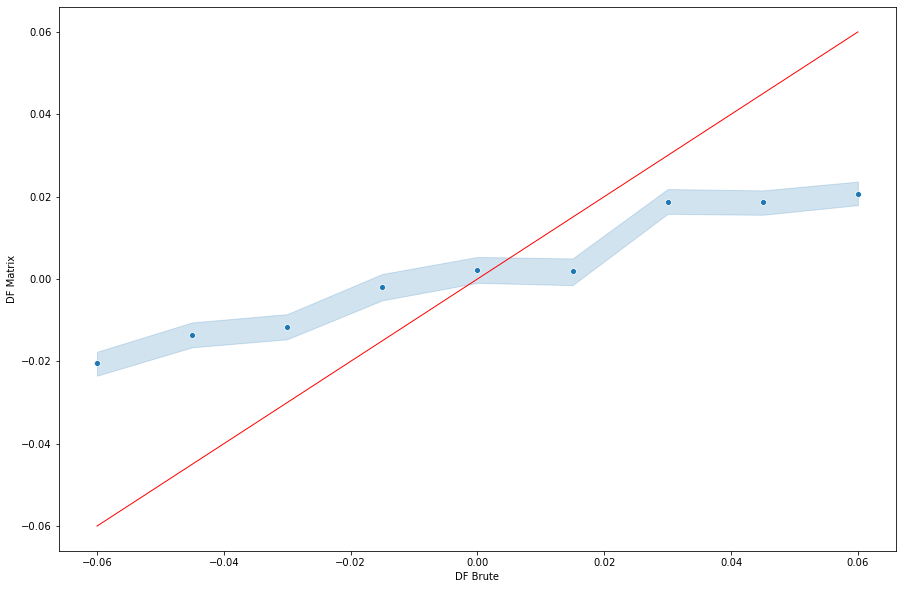

In [19]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Brute",y="DF Matrix",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1,c="r")


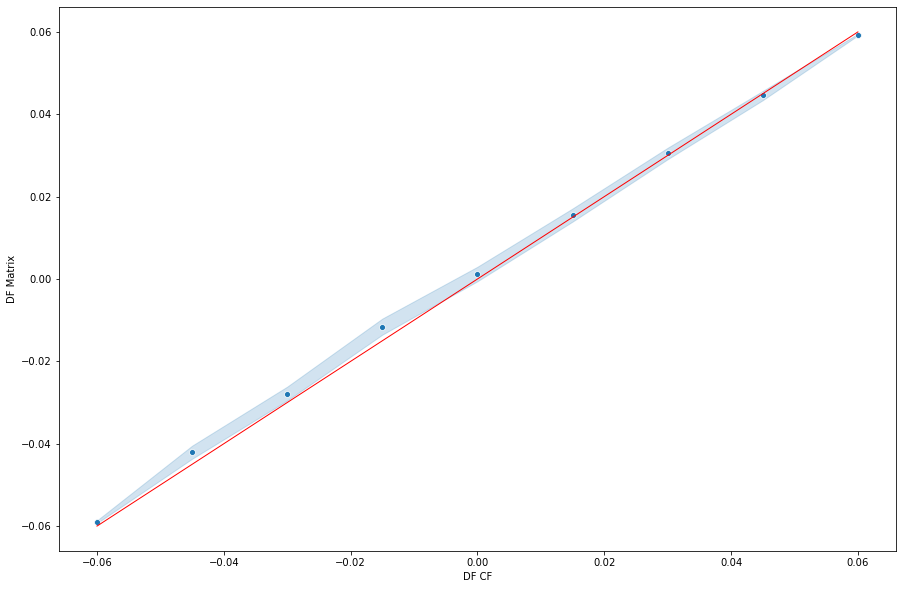

In [20]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF CF",y="DF Matrix",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1,c="r")


## MRF sequence

In [152]:

base_folder = "../3D"


suffix=""
nb_filled_slices = 8
nb_empty_slices=2
repeat_slice=1
nb_slices = nb_filled_slices+2*nb_empty_slices

undersampling_factor=1


name = "SquareSimu3D"

localfile="/"+name
filename = base_folder+localfile

folder = "/".join(str.split(filename,"/")[:-1])


filename_paramMap=filename+"_paramMap_sl{}_rp{}{}.pkl".format(nb_slices,repeat_slice,suffix)
filename_volume = filename+"_volumes_sl{}_rp{}_us{}{}.npy".format(nb_slices,repeat_slice,undersampling_factor,suffix)
filename_mask= filename+"_mask_sl{}_rp{}_us{}{}.npy".format(nb_slices,repeat_slice,undersampling_factor,suffix)
dictfile='../mrf175_SimReco2_light.dict'

In [153]:
mask=np.load(filename_mask)
volumes_all=np.load(filename_volume)
with open(filename_paramMap, "rb") as file:
    paramMap=pickle.load(file)


In [154]:
all_signals=volumes_all[:,mask>0]
all_signals/=np.linalg.norm(all_signals,axis=0)

In [189]:
nb_signals=1000

In [190]:
total_nb_signals=all_signals.shape[1]

nb_signals=np.minimum(total_nb_signals,nb_signals)
ind=np.random.choice(total_nb_signals,size=nb_signals,replace=False)
ff_gt=paramMap["ff"][ind]
df_gt=paramMap["df"][ind]

all_signals=all_signals[:,ind]


In [191]:
pca = True
threshold_pca_bc = 20
threshold_pca_brute=20

In [192]:
nb_signals=all_signals.shape[1]
split=nb_signals+1
dict_optim_brute=BruteDictSearch(FF_list=np.arange(0,1.01,0.01),mask=mask,split=split,pca=pca,threshold_pca=threshold_pca_brute,log=False,useGPU_dictsearch=False,ntimesteps=None,log_phase=False,return_matched_signals=True)
dict_optim_bc =SimpleDictSearch(mask=mask, niter=0, seq=None, trajectory=None, split=split, pca=pca,
                                threshold_pca=threshold_pca_bc, log=False, useGPU_dictsearch=False, useGPU_simulation=False,
                                gen_mode="other", movement_correction=False, cond=None, ntimesteps=None,return_matched_signals=True)
#dict_optim_bc_matrix = dict_optim_bc_cf



all_maps_brute,matched_signals_brute=dict_optim_brute.search_patterns(dictfile,all_signals)
all_maps_bc_cf,matched_signals_bc_cf=dict_optim_bc.search_patterns_test(dictfile,all_signals)
all_maps_bc_matrix,matched_signals_bc_matrix=dict_optim_bc.search_patterns_matrix(dictfile,all_signals)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Calculating optimal fat fraction and best pattern per signal
There are 100 unique signals to match along 87264 dic components


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


Building the maps for iteration


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Water Components Retained 20 out of 175 timesteps
Fat Components Retained 20 out of 175 timesteps
################# ITERATION : Number 0 out of 0 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 0
There are 100 unique signals to match along 864 water and 72 fat components
(100,)
(100,)
(175, 100)
Maps build for iteration 0
There are 100 unique signals to match along 864 components


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.89it/s]


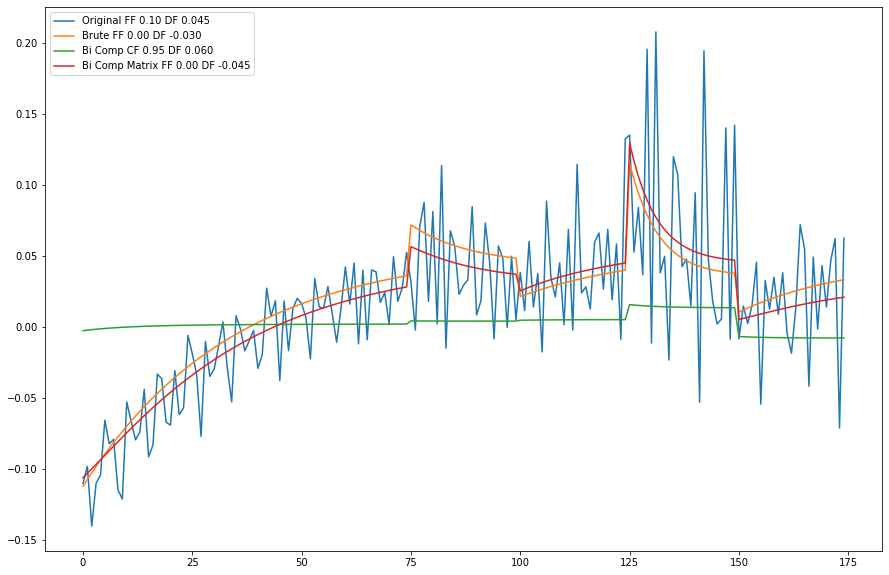

In [201]:
j=np.random.choice(nb_signals)
j=34
metric=np.real
plt.figure(figsize=(15,10))
plt.plot(metric(all_signals[:,j]),label="Original FF {0:.2f} DF {1:.3f}".format(ff_gt[j],df_gt[j]))
plt.plot(metric(matched_signals_brute[:,j]),label="Brute FF {0:.2f} DF {1:.3f}".format(all_maps_brute[0][0]["ff"][j],all_maps_brute[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_cf[:,j]),label="Bi Comp CF {0:.2f} DF {1:.3f}".format(all_maps_bc_cf[0][0]["ff"][j],all_maps_bc_cf[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_matrix[:,j]),label="Bi Comp Matrix FF {0:.2f} DF {1:.3f}".format(all_maps_bc_matrix[0][0]["ff"][j],all_maps_bc_matrix[0][0]["df"][j]))
plt.legend()

In [195]:
correls_bc_matrix=[]
correls_bc_cf=[]
correls_brute=[]

correls_brute=[]
for i in range(nb_signals):
    correls_bc_matrix.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_matrix[:,i]))[0,1])
    correls_brute.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_brute[:,i]))[0,1])
    correls_bc_cf.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_cf[:,i]))[0,1])
    
correls_bc_matrix=np.array(correls_bc_matrix)
correls_bc_cf=np.array(correls_bc_cf)
correls_brute=np.array(correls_brute)
df_correls = pd.DataFrame(columns=["Brute","BC Matrix","BC CF"],data=np.stack([correls_brute,correls_bc_matrix,correls_bc_cf],axis=-1))

<Figure size 1080x720 with 0 Axes>

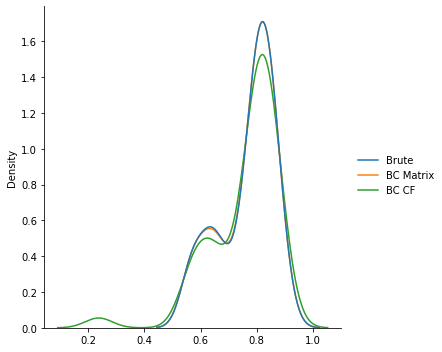

In [196]:
import seaborn as sns
plt.figure(figsize=(15,10))

sns.displot(df_correls,kind="kde");

In [197]:
print(df_correls.describe())

            Brute   BC Matrix       BC CF
count  100.000000  100.000000  100.000000
mean     0.765272    0.765510    0.756493
std      0.097421    0.097292    0.121952
min      0.560884    0.560894    0.238032
25%      0.682311    0.685657    0.682311
50%      0.805056    0.805045    0.805047
75%      0.839669    0.839681    0.839681
max      0.905829    0.905990    0.905829


In [198]:
np.argsort(correls_bc_cf)

array([34, 60, 71, 97, 36, 86, 49, 47, 91, 48,  5, 61, 74, 62, 51, 38, 13,
       55, 39, 82, 66, 69,  9,  8, 94, 17, 98, 24, 85, 65, 79, 80, 30, 68,
       10, 53, 44,  6, 22, 90, 73, 99, 11, 16, 67, 57,  3, 50, 77, 93, 32,
       81, 29, 40, 87,  4, 33, 14, 15, 63, 70, 35,  7, 75, 27, 46, 43, 52,
       37, 59, 23, 21, 78, 18, 89, 20, 84, 42, 45,  1, 76, 95, 25,  2, 19,
       83, 31, 12, 58, 92, 72, 26, 54, 96, 41,  0, 28, 56, 64, 88])